In [2]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

%matplotlib inline

/Users/weishenwang/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [43]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

data = TBAs[4.5]['2010-01-01':]
prices = data.price.values
rates = data.MTGFNCL.values / 100

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]

dates = data.index[1:]

## 1. Rolling Window Regression

In [44]:
window = 120
D = []
R_sq_r = []
for t in range(len(delta_r) - window):
    y = ret[t : t+window]
    x = delta_r[t : t+window]
    model = sm.OLS(y, x)
    result = model.fit()
    D.append(- result.params[0])
    R_sq_r.append(result.rsquared)

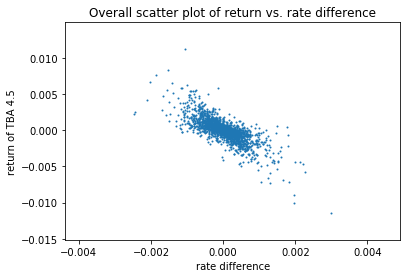

In [65]:
plt.scatter(delta_r,ret,s=1)
plt.xlabel("rate difference")
plt.ylabel("return of TBA 4.5")
plt.title("Overall scatter plot of return vs. rate difference")

## 2. Kalman Filter

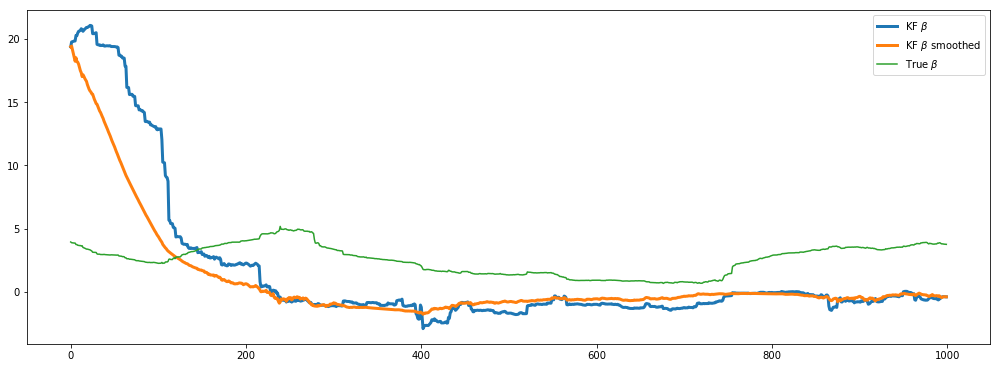

In [5]:
# Run Kalman filter on returns data
Total_T = 1000

delta_r = 1e-2
trans_cov_r = delta_r / (1 - delta_r) * np.eye(2) # How much random walk wiggles
obs_mat_r = np.expand_dims(np.vstack([[D[:Total_T]], [np.ones(Total_T)]]).T, axis=1)


kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y_r is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[-D[0],0],
                  initial_state_covariance=np.ones((2, 2)),
                    
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat_r,
                  
                  observation_covariance=.01,
                  transition_covariance=trans_cov_r)

theta = kf_r.em(prices[:Total_T])
state_means_r, _ = kf_r.filter(prices[:Total_T])
state_means_r_smooth, _ = kf_r.smooth(prices[:Total_T])

fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(2, 1, 1)
#_, axarr = plt.subplots(2, sharex=True)
ax.plot(state_means_r[:,0], label=r'KF $\beta$', lw=3)
ax.plot(state_means_r_smooth[:,0], label=r'KF $\beta$ smoothed', lw=3)
ax.plot(D[:Total_T], label=r'True $\beta$')
ax.legend()

fig.tight_layout()


## 3. OAS linear Regression.

In this part, we calculate the Pseudo-OAS. This is defined as assume a bond with coupon 4.5 (in this case), paid out without any prepayment. Then use the 10-year treasury rate as a flat yield curve, finding the pseudo-OAS we need add over this rate, so that we will match the present value to market price. For example, assume par is 100
Solve for c
$$
100 = \sum_{i=1}^{360} \frac{c}{(1 + \frac{4.5\%}{12})^i}
$$

Then find OAS:

$$
P_{market} = \sum_{i=1}^{360} \frac{c}{(1 + \frac{r_{10y} + OAS}{12})^i}
$$

In [45]:
rate_Base_raw['Date'] = pd.to_datetime(rate_Base_raw['Date'])
rate_Base_raw.index = rate_Base_raw['Date']
new_df = pd.concat([data, rate_Base_raw], join_axes=[data.index], axis=1)
new_df.head()

,coupon,price,MTGFNCL,Spread,Year,Date,MTGFNCL,CMMFIX,TR
Date,,,,,,,,,
2010-01-04,4.5,99.708244,4.512,-0.012,2010,2010-01-04,4.512,4.5319,3.8155
2010-01-05,4.5,100.254445,4.434,0.066,2010,2010-01-05,4.434,4.4392,3.7608
2010-01-06,4.5,100.090517,4.479,0.021,2010,2010-01-06,4.479,4.4654,3.8215
2010-01-07,4.5,99.867188,4.524,-0.024,2010,2010-01-07,4.524,4.5063,3.8235
2010-01-08,4.5,99.908482,4.521,-0.021,2010,2010-01-08,4.521,4.4980,3.8297


In [46]:
from scipy import optimize
def cal_NPV(coupon, rate, maturity = 30):
    total_mont = maturity * 12
    N = 100
    cash = N / np.sum([(1 + coupon / 1200)**(-t -1) for t in range(total_mont)])
    dt = np.arange(1, total_mont +1) / 12
    disc = np.array([(1 + rate/1200)**(-t-1) for t in range(total_mont)])
    npv = np.sum(disc) * cash
    return npv




def cal_disc(dis, price, coupon):
    
    return price - cal_NPV(coupon, dis)


discont = []
for i in new_df.index:
    coupon = 4.5
    TR = new_df.loc[i]['TR']
    p = new_df.loc[i]['price']
    discont.append(optimize.fsolve(cal_disc, 4.5,args=(p,4.5))[0])

new_df['sp'] = discont
new_df['OAS'] = new_df['sp'] - new_df['TR']


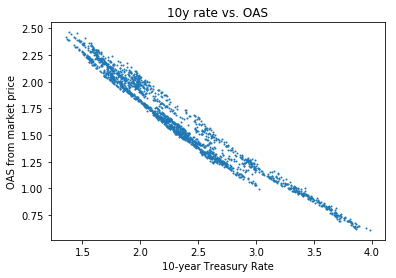

In [59]:
plt.scatter(new_df['TR'],new_df['OAS'],s=1)
plt.xlabel("10-year Treasury Rate")
plt.ylabel("OAS from market price")
plt.title("10y rate vs. OAS")
plt.show()

In [23]:
def cal_price(coupon, rate, OAS, maturity = 30):
    total_mont = maturity * 12
    N = 100
    cash = N / np.sum([(1 + coupon / 1200)**(-t -1) for t in range(total_mont)])
    dt = np.arange(1, total_mont +1) / 12
    disc = np.array([(1 + (rate+OAS)/1200)**(-t-1) for t in range(total_mont)])
    p = np.sum(disc) * cash
    return p

In [51]:
Y = new_df['OAS']
X = new_df['TR']


window = 120
D_OAS = []
R_sq_OAS = []
de_r = 0.01
for t in range(len(Y) - window):
    y = Y[t : t+window]
    x = X[t : t+window]
    model = sm.OLS(y, sm.add_constant(x))
    result = model.fit()
    slope = result.params[1]
    R_sq_OAS.append(result.rsquared)
    last_OAS = y[-1]
    last_rate = x[-1]
    
    p_higher = cal_price(4.5, last_rate + de_r, last_OAS + slope*de_r)
    p_lower = cal_price(4.5, last_rate - de_r , last_OAS - slope * de_r)
    p = cal_price(4.5, last_rate, last_OAS)
    Duration = - 100 * (p_higher - p_lower) / (2 * de_r * p)
    D_OAS.append(Duration)
    

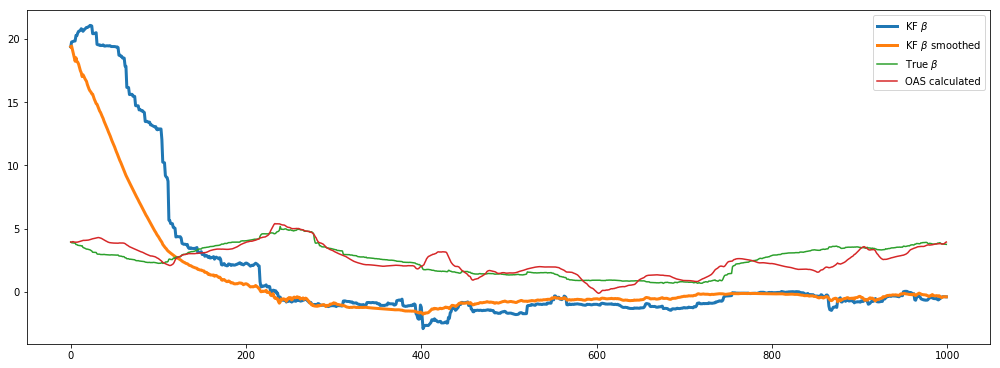

In [52]:
fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(2, 1, 1)
#_, axarr = plt.subplots(2, sharex=True)
ax.plot(state_means_r[:,0], label=r'KF $\beta$', lw=3)
ax.plot(state_means_r_smooth[:,0], label=r'KF $\beta$ smoothed', lw=3)
ax.plot(D[:Total_T], label=r'True $\beta$')
ax.plot(D_OAS[:Total_T], label='OAS calculated')
ax.legend()

fig.tight_layout()


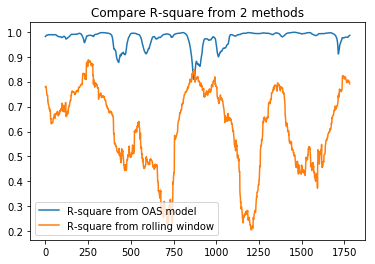

In [60]:
plt.plot(R_sq_OAS,label = 'R-square from OAS model')
plt.plot(R_sq_r, label = 'R-square from rolling window')
plt.title("Compare R-square from 2 methods")
plt.legend()
plt.show()

As we compare the rolling regression between return and rate difference, and rolling regression between OAS and 10-y rate, the R-square differs a lot. In general, the relationship between OAS and 10-y is linear and R-square is almost over 90% all the time, while the return and rate difference is not quite linear, R-square is so volatile and in average around 60%.

